In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchaudio
import torch
import numpy as np
import os
import pickle
import re
import torchaudio.transforms as T
import math



torch.manual_seed(1)

In [21]:
file = open('/project/graziul/data/Zone1/2018_08_04/2018_08_04vad_dict.pkl','rb')
vad_dict = pickle.load(file)

In [22]:
test_key = list(vad_dict.keys())[0]
vad_dict[test_key]

{'pydub': {-24: {'nonsilent_slices': [[392854, 394170],
    [395263, 395267],
    [397620, 398701],
    [399578, 409655],
    [410254, 410656],
    [411215, 411220],
    [414952, 416884],
    [418455, 418461],
    [824867, 825037],
    [825665, 826898],
    [828423, 828427],
    [829500, 830273],
    [830861, 838611],
    [839113, 842452],
    [843753, 843953],
    [845021, 845763],
    [846627, 850160],
    [850738, 851675],
    [852412, 853170],
    [853794, 855787],
    [856386, 858849],
    [859979, 859982],
    [867465, 868866],
    [870249, 871474],
    [872242, 873340],
    [874666, 874864],
    [875933, 879834],
    [880956, 880960],
    [1631361, 1633400],
    [1634783, 1634786],
    [1635967, 1638723],
    [1639276, 1639316],
    [1640028, 1644938],
    [1646046, 1649121],
    [1650149, 1650152]],
   'nonsilent_minutes': 0.9895676492819349}}}

In [53]:
a = audio_file(test_key)
a.get_slices(vad_dict)
input_list.append(a.get_mfcc()[:,:,:180409])
a.get_frames()
labels_list.append(a.get_labels()[:180409])

In [54]:
t = a.get_mfcc()
t.size()

torch.Size([1, 40, 183714])

In [2]:
def divide_audio(datafile, div_size = 29): #Divide the audio clip into bits of 1 minute each
#resizes input arrays from (1,feature_length, time) to (div_size,feature_length,time/div_length)
    return np.reshape(datafile,[div_size,datafile.shape[1],datafile.shape[2]//div_size])

class audio_file():
    def __init__(self, name):
        self.name = name
        self.vad_slices = None
        self.frames = None
        self.frames_labels = None
        self.mfcc = None
    
    def get_slices(self, vad_dict):
        self.vad_slices = vad_dict[self.name]['pydub'][-24]['nonsilent_slices']
        return self.vad_slices
    
    def get_frames(self):
        ms_2_sample = self.sample_rate/1000
        frames_array = np.zeros(self.mfcc.shape[2])
        #frames_array = np.zeros(180409)

        for v in self.vad_slices:
            start = math.floor(v[0]*ms_2_sample)
            end = math.ceil(v[1]*ms_2_sample)

            for i in range(start,end):
                n = math.floor(i/220)
                j = i%220
                if j <= 110:
                    frames_array[n-2] += 1
                    frames_array[n-1] += 1
                    frames_array[n] += 1
                elif j>=111 and j<=220:
                    frames_array[n-1] += 1
                    frames_array[n] += 1
                elif j>=221 and j<=330:
                    frames_array[n-1] += 1
                    frames_array[n] += 1
                    frames_array[n+1] += 1
                elif j>=331 and j<=440:
                    frames_array[n+1] += 1
                    frames_array[n] += 1
                elif j>=441:
                    frames_array[n+2] += 1
                    frames_array[n+1] += 1
                    frames_array[n] += 1
            
            self.frames = frames_array
            return self.frames
        
    def get_labels(self): 
        self.frames_labels = np.zeros(len(self.frames))
        self.frames_labels[np.where(self.frames>0)] = 1
        return self.frames_labels
    
    def get_mfcc(self): 
        file_name = '/project/graziul/data/Zone1/2018_08_04/' + self.name
        self.waveform, self.sample_rate = torchaudio.load(file_name)
        n_fft = 2048
        win_length = 551
        hop_length = 220
        n_mels = 40
        n_mfcc = 40

        mfcc_transform = T.MFCC(
            sample_rate=self.sample_rate,
            n_mfcc=n_mfcc,
            melkwargs={
              'n_fft': n_fft,
              'n_mels': n_mels,
              'hop_length': hop_length,
              'mel_scale': 'htk',
            }
        )

        self.mfcc = mfcc_transform(self.waveform)
        return self.mfcc

In [23]:
input_list = []
labels_list = []

for idx,key in enumerate(vad_dict):
    print(idx)
    a = audio_file(key)
    a.get_slices(vad_dict)
    input_list.append(a.get_mfcc()[:,:,:180409])
    a.get_frames()
    labels_list.append(a.get_labels()[:180409])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


In [30]:
input_list = torch.cat(input_list[:31])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [3]:
f = '/project/graziul/ra/anishk/VAD/Source/Data/data1.pt'
data = torch.load(f)
data = np.transpose(data, (0, 2, 1))

In [4]:
data.shape

torch.Size([1, 183714, 40])

# Initialize LSTM
Pytorch’s LSTM expects all of its inputs to be 3D tensors. The semantics of the axes of these tensors is important. The first axis is the sequence itself, the second indexes instances in the mini-batch, and the third indexes elements of the input. 

In [7]:
input_dim = 40
hidden_dim = 64 
n_layers = 3 

lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)

batch_size = 1

hidden_state = torch.randn(n_layers, batch_size, hidden_dim)
cell_state = torch.randn(n_layers, batch_size, hidden_dim)
hidden = (hidden_state, cell_state)

out, hidden = lstm(data, hidden)

In [8]:
def temp_attention(hidden_feature_map):
    H_maxtemp = torch.max(hidden_feature_map, 1).values
    H_avgtemp = torch.mean(hidden_feature_map, 1)
    H_stdtemp = torch.std(hidden_feature_map, 1)
    H_concattemp = torch.cat([H_maxtemp[None, :], H_avgtemp[None, :], H_stdtemp[None,:]], dim=0)
    return H_concattemp

def freq_attention(hidden_feature_map):
    H_maxfreq = torch.max(hidden_feature_map, 0).values
    H_avgfreq = torch.mean(hidden_feature_map, 0)
    H_stdfreq = torch.std(hidden_feature_map, 0)
    H_concatfreq = torch.cat([H_maxfreq[None, :], H_avgfreq[None, :], H_stdfreq[None,:]], dim=0)
    return H_concatfreq 

def convolve(input,H):
    # Define normalization and relu functions for use after first 3 convolutions
    norm = nn.BatchNorm1d(64, affine=False, track_running_stats=False)
    ReLU = nn.ReLU()

    # 1D Convolution; padding of 5 on both sides to account for ndims change
    conv1 = nn.Conv1d(3,3, kernel_size=11, padding=5)
    output = conv1(input)
    output = norm(output)
    output = ReLU(output)
    
    conv2 = nn.Conv1d(3,5, kernel_size=11, padding=5)
    input = output
    output = conv2(input)
    output = norm(output)
    output = ReLU(output)
    
    conv3 = nn.Conv1d(5,5, kernel_size=11, padding=5)
    input = output
    output = conv3(input)
    output = norm(output)
    output = ReLU(output)
    
    conv4 = nn.Conv1d(5,1, kernel_size=11, padding=5)
    input = output
    H_temp = conv4(input)
    # "Expand/copy" output of last layer (H_temp) to same dims as H
    H_temp = H_temp.expand(-1,64,-1)
    # Sigmoid activation     
    sigmoid = nn.Sigmoid()
    input = H_temp
    H_temp = sigmoid(input)
    H_temp = torch.transpose(H_temp, 1, 2)[0]
    # Merge H_temp and H by element wise summation
    H_prime = torch.stack((H,H_temp))
    H_prime = torch.sum(H_prime,0)
    return H_prime

#H = out[0] ##H is the "Hidden feature map"
#input = temp_attention(H)[None,:] ## batch_size, channels, features
#output = convolve(input,H)

In [9]:
def display(tensor):
    input = tensor.detach().numpy()
    a = plt.hist(input[0][0], bins = 50)
    b = plt.hist(input[0][1], bins = 50)
    c = plt.hist(input[0][2], bins = 50)
    plt.show()
    d = print('max:',np.max(input))
    e = print('min:',np.min(input))
    range = np.max(input)-np.min(input)
    f = print('range:',range)
    return 

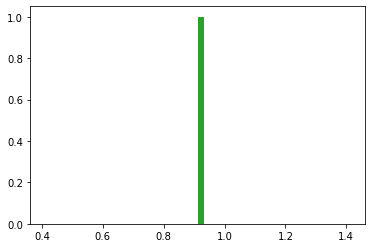

max: 0.9705805
min: 0.00013183792
range: 0.9704487


In [58]:
H = out[0] ##H is the "Hidden feature map"
input = temp_attention(H)[None,:] ## batch_size, channels, features

# Define normalization and relu functions for use after first 3 convolutions
norm = nn.BatchNorm1d(64, affine=False, track_running_stats=False)
ReLU = nn.ReLU()

# 1D Convolution; padding of 5 on both sides to account for ndims change
conv1 = nn.Conv1d(3,3, kernel_size=11, padding=5)
output = conv1(input)
output = norm(output)
output = ReLU(output)

conv2 = nn.Conv1d(3,5, kernel_size=11, padding=5)
input = output
output = conv2(input)
output = norm(output)
output = ReLU(output)


conv3 = nn.Conv1d(5,5, kernel_size=11, padding=5)
input = output
output = conv3(input)
output = norm(output)
output = ReLU(output)

conv4 = nn.Conv1d(5,1, kernel_size=11, padding=5)
input = output
H_temp = conv4(input)
# "Expand/copy" output of last layer (H_temp) to same dims as H
H_temp = H_temp.expand(-1,64,-1)
# Sigmoid activation     
sigmoid = nn.Sigmoid()
input = H_temp
H_temp = sigmoid(input)
H_temp = torch.transpose(H_temp, 1, 2)[0]
# Merge H_temp and H by element wise summation
H_prime = torch.stack((H,H_temp))
H_prime = torch.sum(H_prime,0)
display(H_temp)

In [77]:
# Same parameters as LSTM1 except for input dim

output = output[0,:,:,:]
output = torch.transpose(output,1,2)
input_dim = 5
hidden_dim = 64 
n_layers = 3 

lstm2 = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)

batch_size = 1

hidden_state = torch.randn(n_layers, batch_size, hidden_dim)
cell_state = torch.randn(n_layers, batch_size, hidden_dim)
hidden = (hidden_state, cell_state)

out, hidden = lstm2(output, hidden)

In [86]:
print(out.size())

torch.Size([1, 183714, 64])


In [88]:
linear1 = nn.Linear(64, 64)
linear1_output = linear1(out)

linear2 = nn.Linear(64, 1)
linear2_output = linear2(linear1_output)

sigmoid = nn.Sigmoid()
input = linear2_output
output_binary = sigmoid(input)

In [ ]:
input = 

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
optimizer.zero_grad()
loss_fn(model(input), target).backward()
optimizer.step()

torch.Size([2, 180409, 40])

In [127]:
class StackedLSTM(nn.Module):
    def __init__(self):
        super(StackedLSTM, self).__init__()
        self.input_dim1 = 40
        self.input_dim2 = 64 
        self.hidden_dim = 64
        self.n_layers = 3
        self.batch_size = 2 #184714 makes the code run
        #(input is of format batch_size, sequence_length, num_features)
        #hidden states should be (num_layers, batch_size, hidden_length)
        self.hidden_state1 = torch.randn(self.n_layers, self.batch_size, self.hidden_dim)
        self.cell_state1 = torch.randn(self.n_layers, self.batch_size, self.hidden_dim)
        self.hidden_state2 = torch.randn(self.n_layers, self.batch_size, self.hidden_dim)
        self.cell_state2 = torch.randn(self.n_layers, self.batch_size, self.hidden_dim)
        self.lstm1 = nn.LSTM(input_size = self.input_dim1, hidden_size = self.hidden_dim, num_layers = self.n_layers, batch_first=True) #should be True
        self.lstm2 = nn.LSTM(input_size = self.input_dim2, hidden_size = self.hidden_dim, num_layers = self.n_layers, batch_first=True) #should be True
        self.lstm2_out = None 
        self.hidden = None
        #self.flatten = nn.Flatten()
        self.convolve1d = nn.Sequential(
            nn.Conv1d(3,3, kernel_size=11, padding=5),
            nn.BatchNorm1d(64, affine=False, track_running_stats=False),
            nn.ReLU(),
            nn.Conv1d(3,5, kernel_size=11, padding=5),
            nn.BatchNorm1d(64, affine=False, track_running_stats=False),
            nn.ReLU(),
            nn.Conv1d(5,5, kernel_size=11, padding=5),
            nn.BatchNorm1d(64, affine=False, track_running_stats=False),
            nn.ReLU(),
            nn.Conv1d(5,1, kernel_size=11, padding=5)
        )
        self.output_stack = nn.Sequential(
            nn.Linear(64, 64),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

#     def create_rand_hidden1(self):
#         self.hidden_state1 = torch.randn(self.n_layers, self.batch_size, self.hidden_dim)
#         self.cell_state1 = torch.randn(self.n_layers, self.batch_size, self.hidden_dim)
#         return (self.hidden_state1, self.cell_state1)

    def temp_attention(self, data):
        self.output, hidden = self.lstm1(data, (self.hidden_state1, self.cell_state1))
        self.H = self.output
        self.H_maxtemp = torch.unsqueeze(torch.max(self.H, -1).values,2)
        self.H_avgtemp = torch.unsqueeze(torch.mean(self.H, -1),2)
        self.H_stdtemp = torch.unsqueeze(torch.std(self.H, -1),2)
        self.H_concattemp = torch.cat([self.H_maxtemp, self.H_avgtemp, self.H_stdtemp], dim=2)
        self.H_concattemp = torch.transpose(self.H_concattemp, 1,2)
        return self.H_concattemp 
    
    def convolve1(self, data):
        self.H_temp = self.convolve1d(self.temp_attention(data))
        # "Expand/copy" output of last layer (H_temp) to same dims as H
        self.H_temp = self.H_temp.expand(-1,64,-1)
        # Sigmoid activation     
        sigmoid = nn.Sigmoid()
        self.input = self.H_temp
        self.H_temp = sigmoid(self.input)
        self.H_temp = torch.transpose(self.H_temp, 1, 2)
        # Merge H_temp and H by element wise summation
        self.H_prime = torch.stack((self.H,self.H_temp))
        self.H_prime = torch.sum(self.H_prime,0)
        return self.H_prime
        
#     def create_rand_hidden2(self):
#         self.hidden_state2 = torch.randn(self.n_layers, self.batch_size, self.hidden_dim)
#         self.cell_state2 = torch.randn(self.n_layers, self.batch_size, self.hidden_dim)
#         return (self.hidden_state2, self.cell_state2)  
    
#     def freq_attention(hidden_feature_map):
#         H_maxfreq = torch.max(hidden_feature_map, 0).values
#         H_avgfreq = torch.mean(hidden_feature_map, 0)
#         H_stdfreq = torch.std(hidden_feature_map, 0)
#         H_concatfreq = torch.cat([H_maxfreq[None, :], H_avgfreq[None, :], H_stdfreq[None,:]], dim=0)
#         return H_concatfreq 

    def forward(self, data):
        self.input = self.convolve1(data)
        self.lstm2_out, self.hidden = self.lstm2(self.input, (self.hidden_state2, self.cell_state2))
        self.output = self.output_stack(self.lstm2_out)
        return torch.squeeze(self.output)

In [11]:
class WeightedFocalLoss(nn.Module):
    "Non weighted version of Focal Loss"
    def __init__(self, alpha=.25, gamma=1):
        super(WeightedFocalLoss, self).__init__()
        self.alpha = torch.tensor([alpha, 1-alpha]).cuda()
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        targets = targets.type(torch.long)
        at = self.alpha.gather(0, targets.data.view(-1))
        pt = torch.exp(-BCE_loss)
        F_loss = at*(1-pt)**self.gamma * BCE_loss
        return F_loss.mean()


In [12]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=1,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):

        ce_loss = F.cross_entropy(input, target,reduction=self.reduction,weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [126]:
output_hat.size()

torch.Size([2, 180409])

In [122]:
model = StackedLSTM()
loss_fn = FocalLoss()

In [123]:
output_hat = model(input_list)

torch.Size([2, 180409, 1])


In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
optimizer.zero_grad()
loss_fn(output_hat, labels[:2]).backward()
optimizer.step()

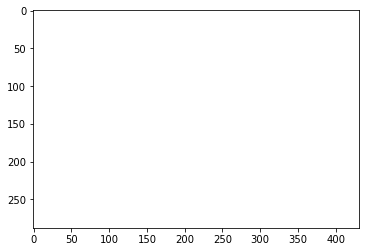

In [105]:
filepath = '/project/graziul/ra/ajays/trimmed_threshold_plots/frame_error_rate_52.png'
import matplotlib.image as img
my_img = img.imread(filepath)
plt.imshow(my_img)